# Classifier drift detector on CIFAR-10

### Method

The classifier-based drift detector simply tries to correctly distinguish instances from the reference data vs. the test set. The classifier is trained to output the probability that a given instance belongs to the test set. If the probabilities it assigns to unseen tests instances are significantly higher (as determined by a Kolmogorov-Smirnoff test) to those it assigns to unseen reference instances then the test set must differ from the reference set and drift is flagged. To leverage all the available reference and test data, stratified cross-validation can be applied and the out-of-fold predictions are used for the significance test. Note that a new classifier is trained for each test set or even each fold within the test set.

### Backend

The method works with both the **PyTorch** and **TensorFlow** frameworks. Alibi Detect does however not install PyTorch for you. 
Check the [PyTorch docs](https://pytorch.org/) how to do this.

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from alibi_detect.cd import ClassifierDrift
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Importing plotly failed. Interactive plots will not work.


### Load data

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [4]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be flagged as drift. We also split the corrupted data by corruption type:

In [5]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [6]:
n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

We can visualise the same instance for each corruption type:

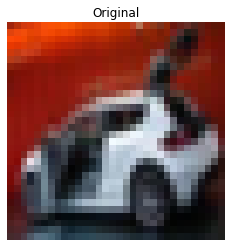

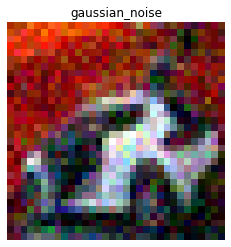

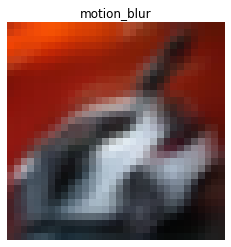

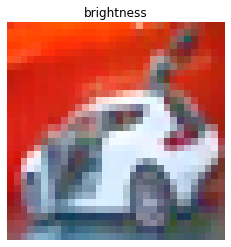

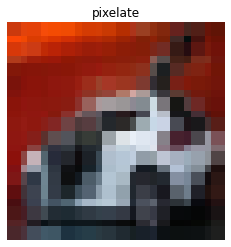

In [7]:
i = 6

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

### Detect drift with a TensorFlow classifier

#### Single fold

We use a simple classification model and try to distinguish between the reference data and the corrupted test sets. The detector defaults to `binarize=False` which means a Kolmogorov-Smirnoff test will be used to test for significant disparity between continuous model predictions (e.g. probabilities or logits). Initially we'll test at a significance level of $p=0.05$, use $75$% of the shuffled reference and test data for training and evaluate the detector on the remaining $25$%. We only train for 1 epoch.

In [8]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input

tf.random.set_seed(0)

model = tf.keras.Sequential(
  [
      Input(shape=(32, 32, 3)),
      Conv2D(8, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(16, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(2, activation='softmax')
  ]
)

cd = ClassifierDrift(X_ref, model, p_val=.05, train_size=.75, epochs=1)

# we can also save/load an initialised detector
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

No model found in my_path/model.


Let's check whether the detector thinks drift occurred on the different test sets and time the prediction calls:

In [9]:
from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print(f'Time (s) {dt:.3f}')
    
    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print(f'p-value: {preds["data"]["p_val"]:.3f}')
            print(f'Time (s) {dt:.3f}')

In [10]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
p-value: 0.556
Time (s) 2.685

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 1.847

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 1.671

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 1.919

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 1.640


As expected, drift was only detected on the corrupted datasets and the classifier could easily distinguish the corrupted from the reference data.

#### Use all the available data via cross-validation

So far we've only used $25$% of the data to detect the drift since $75$% is used for training purposes. At the cost of additional training time we can however leverage all the data via stratified cross-validation. We just need to set the number of folds and keep everything else the same. So for each test set `n_folds` models are trained, and the out-of-fold predictions combined for the significance test:

In [11]:
cd = ClassifierDrift(X_ref, model, p_val=.05, n_folds=5, epochs=1)

Both `n_folds` and `train_size` specified. By default `n_folds` is used.


In [12]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
p-value: 0.475
Time (s) 6.485

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 8.901

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 8.559

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 7.764

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 8.476


### Detect drift with PyTorch classifier

We can do the same with a *PyTorch* instead of a *TensorFlow* model:

In [13]:
import torch
import torch.nn as nn

# set random seed and device
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define classifier model
model = nn.Sequential(
    nn.Conv2d(3, 8, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(8, 16, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(16, 32, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(128, 2)
)

Since our *PyTorch* encoder expects the images in a *(batch size, channels, height, width)* format, we transpose the data. Note that this step could also be passed to the drift detector via the *preprocess_fn* kwarg:

In [14]:
def permute_c(x):
    return np.transpose(x.astype(np.float32), (0, 3, 1, 2))

X_ref_pt = permute_c(X_ref)
X_h0_pt = permute_c(X_h0)
X_c_pt = [permute_c(xc) for xc in X_c]
print(X_ref_pt.shape, X_h0_pt.shape, X_c_pt[0].shape)

(5000, 3, 32, 32) (5000, 3, 32, 32) (10000, 3, 32, 32)


In [15]:
# we again use the cross-validation approach
cd = ClassifierDrift(X_ref_pt, model, backend='pytorch', p_val=.05, n_folds=5, epochs=1)

Both `n_folds` and `train_size` specified. By default `n_folds` is used.
No GPU detected, fall back on CPU.


In [16]:
make_predictions(cd, X_h0_pt, X_c_pt, corruption)

No corruption
Drift? No!
p-value: 1.000
Time (s) 4.715

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 5.863

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 5.504

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 5.186

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 4.817
